In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pickle


In [7]:
PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
temp = df.set_index(['zone_id', 'year', 'month', 'day'])
colname_to_int = {}
for i in list(temp.columns):
    colname_to_int[i] = int(i[1:])

temp = temp.rename(columns=colname_to_int)
temp = temp.stack()
temp = temp.unstack(level=0)
temp.columns.names = [None]
temp.index.names = [None, None, None, None]
df_zone = temp
temp.head(2)

1         2         3      4       5         6         7   \
2004 1 1 1  16853.0  126259.0  136233.0  484.0  6829.0  133088.0  136233.0   
         2  16450.0  123313.0  133055.0  457.0  6596.0  129909.0  133055.0   

                8        9        10       11        12       13       14  \
2004 1 1 1  3124.0  75243.0  23339.0  90700.0  118378.0  20673.0  21791.0   
         2  2956.0  67368.0  22100.0  86699.0  112480.0  19666.0  21400.0   

                 15       16       17        18       19       20  
2004 1 1 1  65970.0  28752.0  30645.0  200946.0  82298.0  79830.0  
         2  64600.0  27851.0  30461.0  195835.0  79827.0  77429.0

## Naive predictors

In [11]:
def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score_multi(train_X, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score_multi(test_X, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score_multi(train_X, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score_multi(test_X, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score_multi(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score_multi(test_X, test_Y)

print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

(Naive -1 hour) Training data error: 1445.17 MSE
(Naive -1 hour) Test data error: 1492.99 MSE
(Naive -1 day) Training data error: 3022.64 MSE
(Naive -1 day) Test data error: 3284.90 MSE
(Naive -1 week) Training data error: 4528.78 MSE
(Naive -1 week) Test data error: 5281.74 MSE


## LSTM 

In [8]:
# use data for zone 1.
data = df_zone[1].values.reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERCENT = 0.80

train_size = int(len(dataset) * TRAINING_PERCENT)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [9]:
def create_dataset_nstep(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

In [15]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
#SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

Train on 26824 samples, validate on 4734 samples
Epoch 1/100
 - 3s - loss: 0.0065 - mse: 0.0065 - mae: 0.0489 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0328
Epoch 2/100
 - 2s - loss: 9.9588e-04 - mse: 9.9587e-04 - mae: 0.0239 - val_loss: 9.0156e-04 - val_mse: 9.0156e-04 - val_mae: 0.0229
Epoch 3/100
 - 2s - loss: 6.8652e-04 - mse: 6.8652e-04 - mae: 0.0198 - val_loss: 6.6434e-04 - val_mse: 6.6434e-04 - val_mae: 0.0194
Epoch 4/100
 - 3s - loss: 5.7149e-04 - mse: 5.7149e-04 - mae: 0.0180 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0264
Epoch 5/100
 - 3s - loss: 4.8073e-04 - mse: 4.8073e-04 - mae: 0.0164 - val_loss: 5.6412e-04 - val_mse: 5.6412e-04 - val_mae: 0.0175
Epoch 6/100
 - 3s - loss: 4.4926e-04 - mse: 4.4926e-04 - mae: 0.0159 - val_loss: 4.4954e-04 - val_mse: 4.4954e-04 - val_mae: 0.0159
Epoch 7/100
 - 3s - loss: 4.0129e-04 - mse: 4.0129e-04 - mae: 0.0149 - val_loss: 4.3022e-04 - val_mse: 4.3022e-04 - val_mae: 0.0151
Epoch 8/100
 - 3s - loss: 3.8374e-04 - mse: 3.8374e

In [17]:
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Training data error: 594.47 MSE
Test data error: 642.20 MSE
Training data error: 20.63 MAE
Test data error: 21.51 MAE


In [23]:
window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [28]:
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Training data error: 2516.00 MSE
Test data error: 2763.08 MSE
Training data error: 42.78 MAE
Test data error: 44.65 MAE


In [30]:
window_size = 1000
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

Train on 25917 samples, validate on 4574 samples
Epoch 1/100
 - 11s - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0820 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0800
Epoch 2/100
 - 7s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0673 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0793
Epoch 3/100
 - 7s - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0666 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0778
Epoch 4/100
 - 7s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0659 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0780
Epoch 5/100
 - 7s - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0655 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0813
Epoch 6/100
 - 7s - loss: 0.0075 - mean_squared_error: 0.007

In [31]:
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Training data error: 3375.22 MSE
Test data error: 4249.99 MSE
Training data error: 50.46 MAE
Test data error: 56.08 MAE


## Multivariable LSTM

In [33]:
PATH = r"../../Data/temperature_history.csv"
df_T = pd.read_csv(PATH)
h_df_T = df_T.set_index(['station_id', 'year', 'month', 'day'])
trans_dict = {}
for i in list(h_df_T.columns):
    trans_dict[i] = int(i[1:])
h_df_T = h_df_T.rename(columns=trans_dict)
h_df_T = h_df_T.stack()
h_df_T = h_df_T.unstack(level=0)
h_df_T.columns = h_df_T.columns.get_level_values(0)
h_df_T.columns.names = [None]
h_df_T.index.names = [None, None, None, None]

PATH = r"../../Data/temperature_solution.csv"
df_T_Sol = pd.read_csv(PATH)
h_df_T_Sol = df_T_Sol.set_index(['station_id', 'year', 'month', 'day', 'hour'])
h_df_T_Sol = h_df_T_Sol.drop(['datetime', 'date'], axis=1)
h_df_T_Sol = h_df_T_Sol.unstack(level=0)
h_df_T_Sol.columns = h_df_T_Sol.columns.get_level_values(1)
h_df_T_Sol.columns.names = [None]
h_df_T_Sol.index.names = [None, None, None, None]

zone_T = pd.concat([h_df_T, h_df_T_Sol], axis=0, join='outer', ignore_index=False, keys=None, 
          levels=None, names=None, verify_integrity=True, copy=True)

T_mean = zone_T.mean(axis=1)
temp['T'] = T_mean

zone_T.head(2)

1     2     3     4     5     6     7     8     9     10    11
2004 1 1 1  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0  42.0  36.0
         2  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0  43.0  32.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FAC150888>,
      dtype=object)

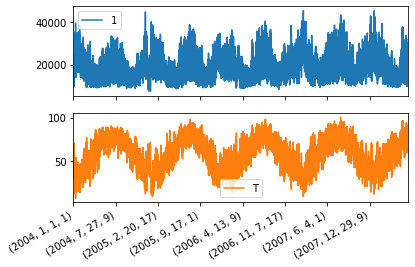

In [34]:
temp[[1, 'T']].plot(subplots=True)

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(temp[[1, 'T']])

# Using 80% of data for training, 20% for validation.
TRAINING_PERCENT = 0.80

train_size = int(len(scaled) * TRAINING_PERCENT)
test_size = len(scaled) - train_size
train_multi, test_multi = scaled[0:train_size, :], scaled[train_size:len(scaled), :]
print("Number of samples training set: " + str((len(train_multi))))
print("Number of samples test set: " + str((len(test_multi))))

Number of samples training set: 31660
Number of samples test set: 7916


In [51]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(200, input_shape = (1, window_size), return_sequences=True))
    vanilla_rnn.add(Dropout(rate = 0.2))
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

Train on 26824 samples, validate on 4734 samples
Epoch 1/100
 - 7s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0353 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 2/100
 - 2s - loss: 7.0408e-04 - mean_squared_error: 7.0408e-04 - mean_absolute_error: 0.0198 - val_loss: 6.9798e-04 - val_mean_squared_error: 6.9798e-04 - val_mean_absolute_error: 0.0197
Epoch 3/100
 - 2s - loss: 5.4853e-04 - mean_squared_error: 5.4853e-04 - mean_absolute_error: 0.0174 - val_loss: 6.9910e-04 - val_mean_squared_error: 6.9910e-04 - val_mean_absolute_error: 0.0198
Epoch 4/100
 - 2s - loss: 4.6189e-04 - mean_squared_error: 4.6189e-04 - mean_absolute_error: 0.0159 - val_loss: 6.7978e-04 - val_mean_squared_error: 6.7978e-04 - val_mean_absolute_error: 0.0198
Epoch 5/100
 - 2s - loss: 4.3178e-04 - mean_squared_error: 4.3178e-04 - mean_absolute_error: 0.0153 - val_loss: 7.1751e-04 - val_mean_squared_error: 7.1751e-04 - val_mean_absolute_error: 0.02

In [52]:
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Training data error: 678.11 MSE
Test data error: 723.86 MSE
Training data error: 22.44 MAE
Test data error: 23.14 MAE


In [39]:
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Training data error: 607.50 MSE
Test data error: 659.49 MSE
Training data error: 21.00 MAE
Test data error: 21.93 MAE


In [21]:
vanilla_rnn.save('lstm_1h_window100.h5') 

In [22]:


vanilla_rnn = load_model('lstm_1h_window100.h5')